<a href="https://colab.research.google.com/github/certainlynotnathan/ML_Regression_Model_Summative-/blob/main/Regression_Model_Summative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Work — Linear Models for Regression

The [NO2 dataset](https://www.openml.org/d/547) provides 500 observations of air pollution largely associated with road traffic. In this lab, your task is to **predict the $NO_2$ concentration** using information about traffic intensity and local atmospheric conditions. Example predictors include vehicles per hour, temperature, wind-related measurements, and indicators for the time of day.

In [15]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
# %matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

# Hide convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [16]:
no2 = oml.datasets.get_dataset(547)
X, y, _, _ = no2.get_data(target=no2.default_target_attribute);
attribute_names = list(X)

## Data
We can use **pandas** to get a quick sense of the dataset. If pandas is new to you, pause here and read the code carefully—it’s worth understanding.

To keep things focused, we will drop the `day` feature and concentrate on the *non-calendar* drivers. This activity is **not** a forecasting task; forecasting would require a different setup (for example, time-aware train/test splits). Also, there is no obvious long-term drift in the series, although temperature clearly shows repeating (periodic) patterns.

/tmp/ipython-input-2707335134.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  df.plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));


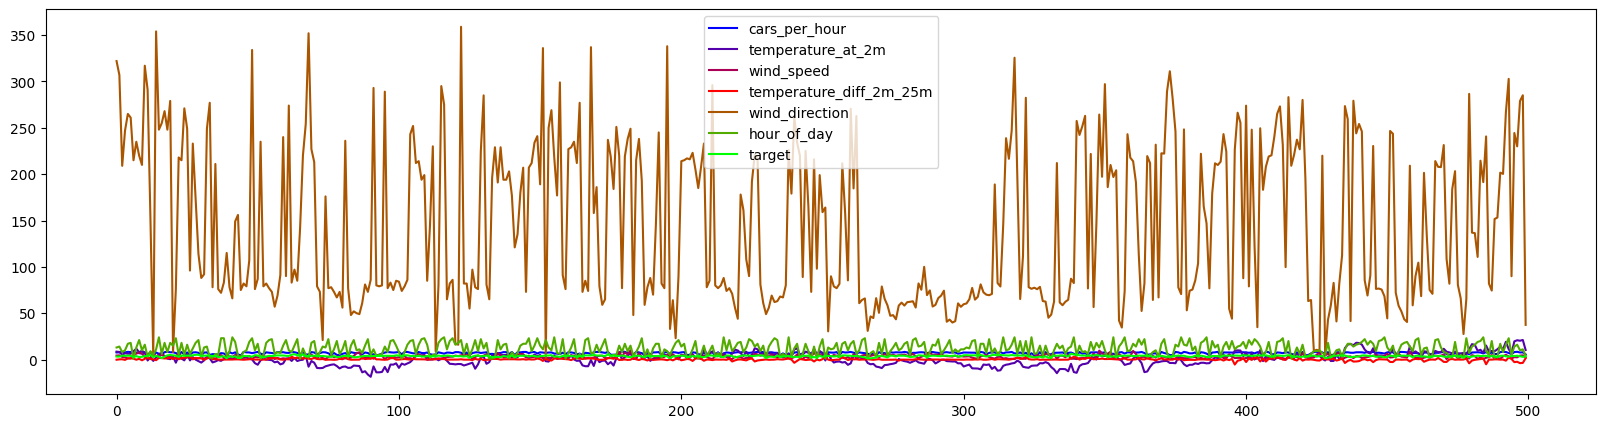

In [17]:

df = pd.DataFrame(X, columns=attribute_names).join(pd.DataFrame(list(y),columns=['target']))
df = df.sort_values(['day','hour_of_day']).drop('day',axis=1)
df.plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));
X = X.drop('day',axis=1)

In [7]:
df.head()

,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,target
42,7.64300,8.5,4.3,-0.2,322.0,13,3.22287
20,7.75061,8.2,4.5,0.2,307.0,14,3.15274
255,8.12415,5.2,2.8,0.3,209.0,8,4.19570
488,7.64108,6.7,2.3,-0.4,247.0,10,3.98155
94,8.31630,6.3,1.2,1.3,265.0,17,4.14155


When we plot the measurements in their recorded order, you’ll notice that `wind_direction` (an angle in degrees) lives on a very different numeric scale than the other variables. To make patterns easier to see, let’s zoom in on the remaining features.

/tmp/ipython-input-2419690043.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  df.drop('wind_direction',axis=1).plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));


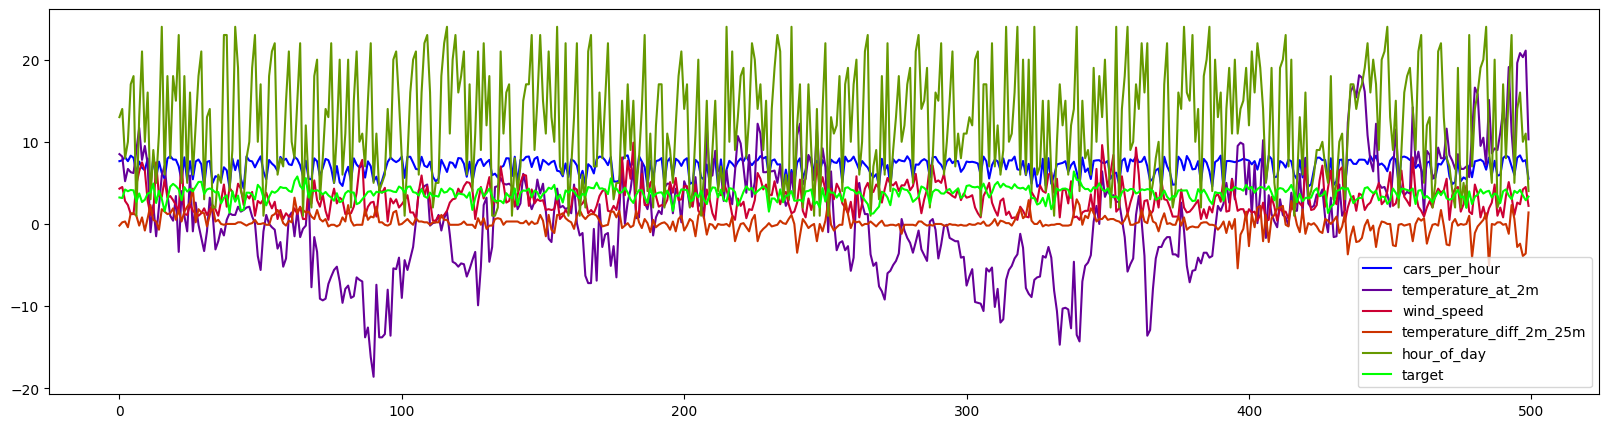

In [8]:
df.drop('wind_direction',axis=1).plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));

The target ($NO_2$ concentration) appears to move together with the *traffic count* (cars per hour), which is reasonable since vehicle emissions contribute to $NO_2$. Other factors—such as temperature and wind—seem to influence the outcome in less direct ways. Next, we’ll try to capture these relationships using **linear models**.

## Exercise 1: Baseline comparison
Because $NO_2$ depends on multiple inputs at once, we will learn a model that combines them. Start by comparing several methods: **Linear Regression**, **Ridge**, **Lasso**, **ElasticNet**, and **kNN**. Since some inputs have very different scales, you will also evaluate pipeline versions that include a **scaling** step. For now, keep all hyperparameters at their default values.

### Exercise 1.1
Write a function that takes a list of models and evaluates each one on the provided data. Your function should return two lists: **training scores** and **test scores** (in the same order as the models). You may import any helpers you need, but you should be able to do this with [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) and standard Python tools. An example of the expected output is shown below the function.

In [18]:
def evaluate_learners(models, X, y):
    """
    Given a list of models [model1, model2, ..., modelN] return two lists:
     - a list with the scores obtained on the training samples for each model,
     - a list with the test scores obtained on the test samples for each model.
     The order of scores should match the order in which the models were originally provided. E.g.:
     [Model1 train score, ..., ModelN train score], [Model1 test score, ..., ModelN test score]
    """
    from sklearn.model_selection import cross_validate
    train_scores = []
    test_scores = []
    for model in models:
        cv_results = cross_validate(model, X, y, cv=5, scoring='r2', return_train_score=True)
        train_scores.append(cv_results['train_score'])
        test_scores.append(cv_results['test_score'])
    return train_scores, test_scores


### Exercise 1.2
Use your evaluation function on: Linear Regression, Ridge, Lasso, ElasticNet, and kNN.
Save the results into `train_scores` and `test_scores`, then run the plotting code below to visualize the comparison.

In [21]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Models without scaling
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    KNeighborsRegressor(),
    Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]),
    Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())]),
    Pipeline([('scaler', StandardScaler()), ('lasso', Lasso())]),
    Pipeline([('scaler', StandardScaler()), ('elasticnet', ElasticNet())]),
    Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())]),
]
train_scores, test_scores = evaluate_learners(models, X, y)


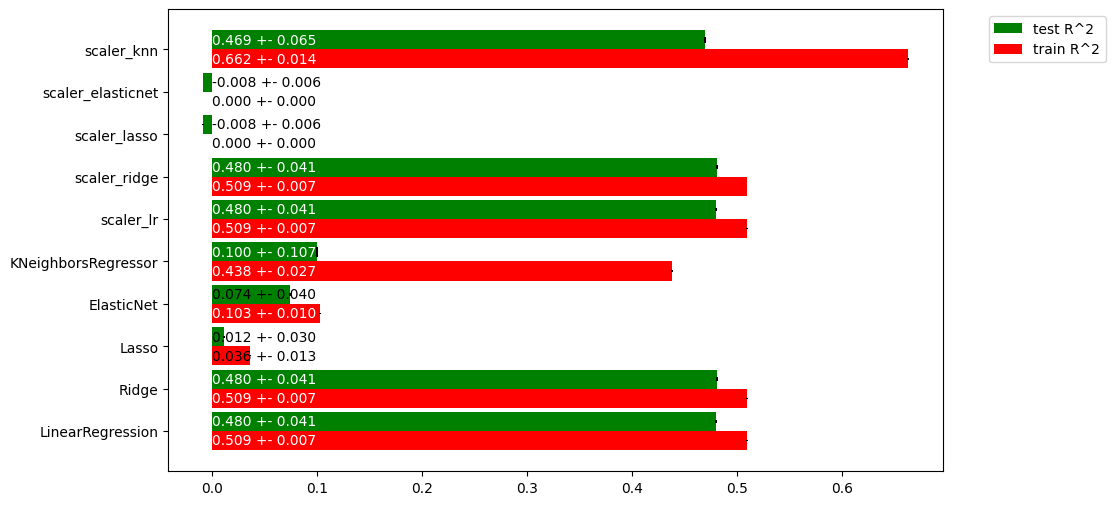

In [22]:
# Plot a bar chart of the train and test scores of all the classifiers, including the variance as error bars
fig, ax = plt.subplots(figsize=(10,6))
width=0.45

ax.barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test R^2')
ax.barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train R^2')
for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    ax.text(0, i, "{:.3f} +- {:.3f}".format(np.mean(te),np.std(te)), color=('white' if np.mean(te)>0.1 else 'black'), va='center')
    ax.text(0, i-width, "{:.3f} +- {:.3f}".format(np.mean(tr),np.std(tr)), color=('white' if np.mean(tr)>0.1 else 'black'), va='center')
labels = [c.__class__.__name__ if not hasattr(c, 'steps') else c.steps[0][0] + "_" + c.steps[1][0] for c in models]
ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=labels)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

### Exercise 1.3
Explain what the plot is telling you. Which regressor looks strongest? Do any models appear to be overfitting? If yes, what adjustment(s) could reduce overfitting? Also comment on whether the results vary a lot across folds (i.e., the amount of variance).

## Exercise 2: Regularization tuning
Next, tune the main *complexity control* for each method: `alpha` for Ridge and Lasso, and `n_neighbors` for kNN.

Search ranges:
- $\alpha \in [10^{-12}, 10^{12}]$ (use a **log scale**, e.g., 0.01, 0.1, 1, 10, 100)
- `n_neighbors` from **1 to 50** (use a **uniform** grid, e.g., 1, 2, 3, 4, ...)


### Exercise 2.1
For each regressor, sweep the hyperparameter ranges above and create a line plot showing **mean training score** and **mean test score** versus the hyperparameter value (5-fold CV is fine). You should end up with **three** plots: one for Ridge/Lasso (alpha) and one for kNN (neighbors).

Hints:
* Be mindful of runtime—too many settings can get slow.
* Useful NumPy helpers: [logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html), [geomspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html?highlight=geomspace#numpy.geomspace), and [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html#numpy.linspace).
* For plotting, Matplotlib’s basic [plot](https://matplotlib.org/tutorials/introductory/pyplot.html) function is enough.
* You can loop manually, or you can explore [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to automate the search (we will revisit it later).

### Exercise 2.2
Discuss the curves you obtained. Where do the models underfit? Where do they overfit? How much does performance change when you tweak the regularization setting?

### Exercise 2.3
ElasticNet blends L1 and L2 regularization. The `l1_ratio` parameter controls how much weight goes to L1 (Lasso) versus L2 (Ridge), so ElasticNet has **two** interacting hyperparameters: `l1_ratio` and `alpha`.

Run a grid search over both parameters to compute cross-validation scores on a 2D grid. Then use the provided function to draw a heatmap and interpret it. What pattern do you see, and how do `alpha` and `l1_ratio` influence each other?

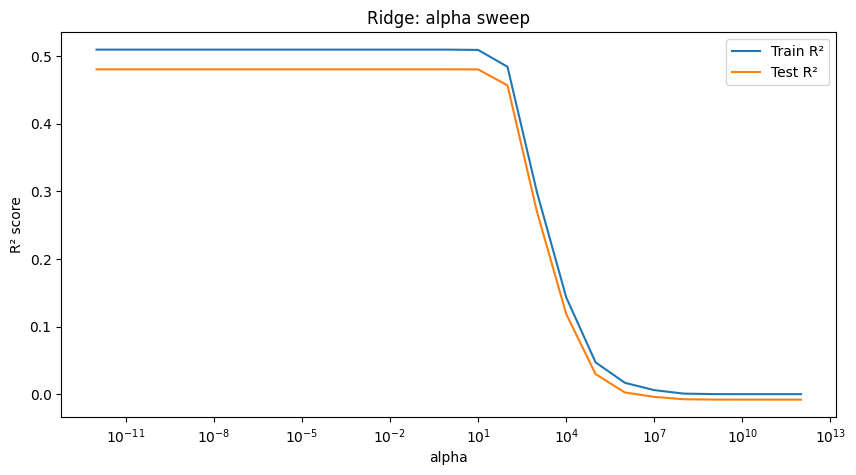

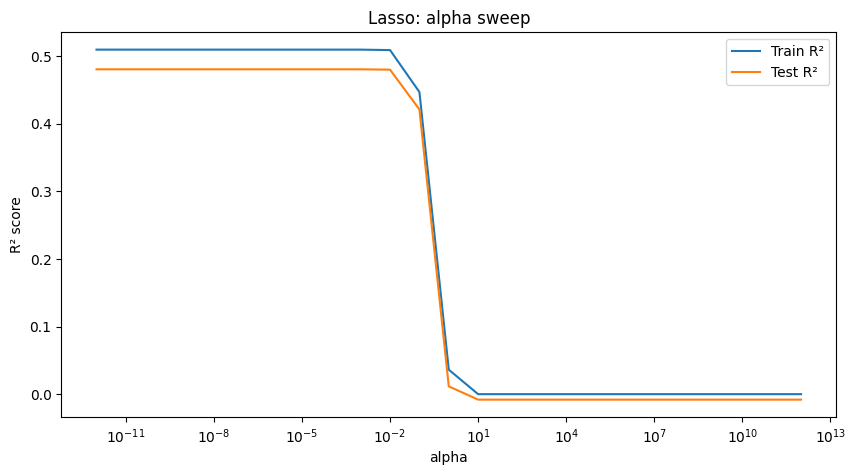

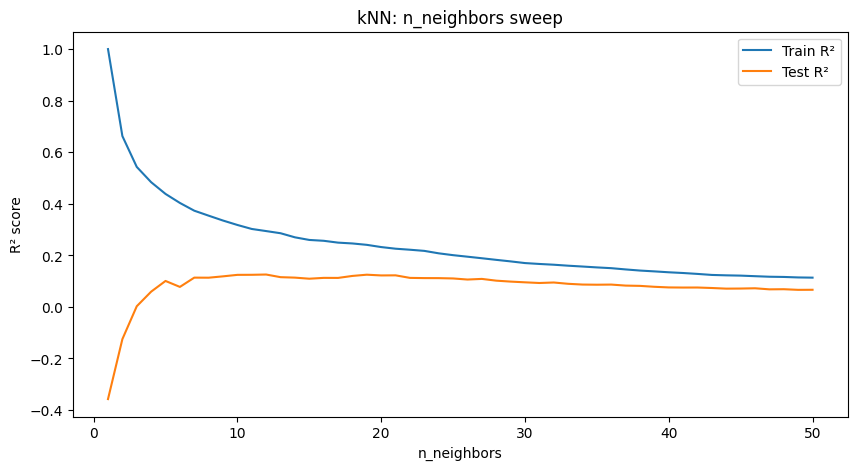

In [23]:
# --- Exercise 2.1: Hyperparameter sweeps ---
from sklearn.model_selection import cross_validate as cv

# Alpha range for Ridge and Lasso
alphas = np.logspace(-12, 12, 25)

# Ridge sweep
ridge_train, ridge_test = [], []
for a in alphas:
    scores = cv(Ridge(alpha=a), X, y, cv=5, scoring='r2', return_train_score=True)
    ridge_train.append(np.mean(scores['train_score']))
    ridge_test.append(np.mean(scores['test_score']))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(alphas, ridge_train, label='Train R²')
ax.plot(alphas, ridge_test, label='Test R²')
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('R² score')
ax.set_title('Ridge: alpha sweep')
ax.legend()
plt.show()

# Lasso sweep
lasso_train, lasso_test = [], []
for a in alphas:
    scores = cv(Lasso(alpha=a), X, y, cv=5, scoring='r2', return_train_score=True)
    lasso_train.append(np.mean(scores['train_score']))
    lasso_test.append(np.mean(scores['test_score']))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(alphas, lasso_train, label='Train R²')
ax.plot(alphas, lasso_test, label='Test R²')
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('R² score')
ax.set_title('Lasso: alpha sweep')
ax.legend()
plt.show()

# kNN sweep
neighbors = np.arange(1, 51)
knn_train, knn_test = [], []
for k in neighbors:
    scores = cv(KNeighborsRegressor(n_neighbors=k), X, y, cv=5, scoring='r2', return_train_score=True)
    knn_train.append(np.mean(scores['train_score']))
    knn_test.append(np.mean(scores['test_score']))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(neighbors, knn_train, label='Train R²')
ax.plot(neighbors, knn_test, label='Test R²')
ax.set_xlabel('n_neighbors')
ax.set_ylabel('R² score')
ax.set_title('kNN: n_neighbors sweep')
ax.legend()
plt.show()


In [ ]:
# Exercise 2.2

In [26]:
# Generic heatmap
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", printvalues=False):
    """
    Plots a heatmap for the performance of a model for every combination of two hyperparameter values

    values: nxn array with all evaluation results, varying the first hyperparameter first
    xlabel: name of the first hyperparameter
    ylabel: name of the second hyperparameter
    xticklabels: values of the first hyperparameter
    yticklabels: values of the second hyperparameter
    cmap: colormap
    vmin: minimal score
    vmax: maximal score
    ax: plot axes
    fmt: format for printing the scores
    printvalues: whether to print the scores
    """
    if ax is None:
        ax = plt.gca()
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    if(printvalues):
        for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.mean(color[:3]) > 0.5:
                c = 'k'
            else:
                c = 'w'
            # Fix: Ensure value is a scalar before formatting
            if np.ma.is_masked(value):
                display_value = np.nan
            elif isinstance(value, (np.ndarray, np.generic)):
                # Safely extract scalar from 0-D or 1-D (size 1) array
                # This covers np.float64, np.array([float]), and MaskedConstant
                try:
                    display_value = value.item()
                except ValueError: # e.g., if value is a multi-element MaskedArray unexpectedly
                    display_value = np.nan # Fallback to NaN
            else:
                display_value = value # Already a Python float
            ax.text(x, y, fmt % display_value, color=c, ha="center", va="center", size=10)
    return img

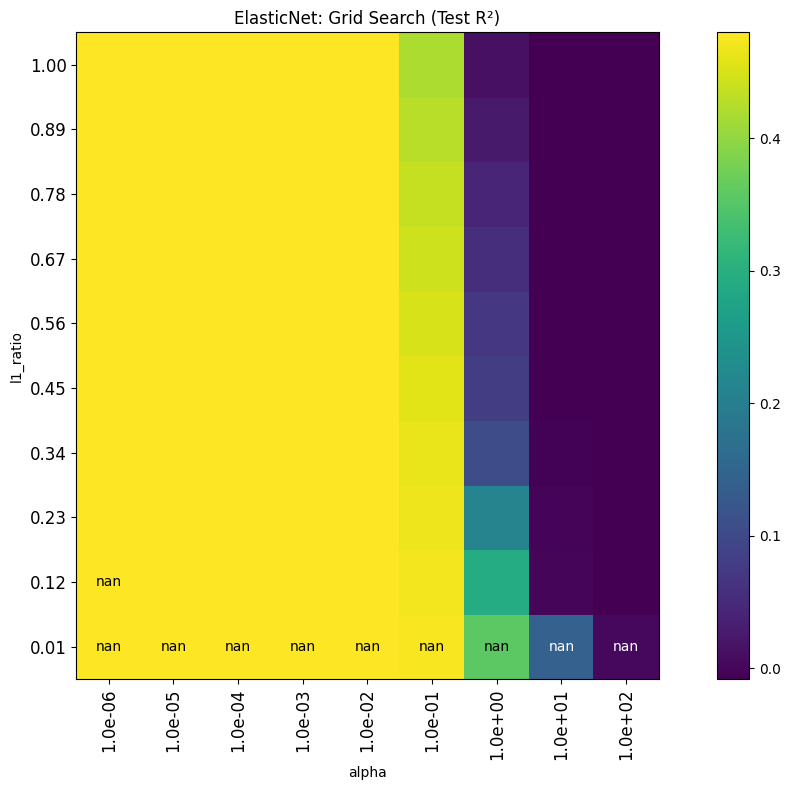

In [28]:
# --- Exercise 2.3: ElasticNet 2D grid search ---
from sklearn.model_selection import GridSearchCV

en_alphas = np.logspace(-6, 2, 9)
en_l1_ratios = np.linspace(0.01, 1.0, 10)

param_grid = {'alpha': en_alphas, 'l1_ratio': en_l1_ratios}
grid = GridSearchCV(ElasticNet(), param_grid, cv=5, scoring='r2', return_train_score=True)
grid.fit(X, y)

# Reshape mean test scores into a 2D array (l1_ratio x alpha)
scores_matrix = np.array(grid.cv_results_['mean_test_score']).reshape(len(en_alphas), len(en_l1_ratios)).T

fig, ax = plt.subplots(figsize=(12, 8))
heatmap(scores_matrix,
        xlabel='alpha',
        ylabel='l1_ratio',
        xticklabels=[f'{a:.1e}' for a in en_alphas],
        yticklabels=[f'{r:.2f}' for r in en_l1_ratios],
        cmap='viridis',
        ax=ax,
        printvalues=True)
ax.set_title('ElasticNet: Grid Search (Test R²)')
plt.colorbar(ax.get_children()[0], ax=ax)
plt.tight_layout()
plt.show()

## Exercise 3: Coefficient comparison
As a final check, compare the coefficients learned by the optimized linear models.

### Exercise 3.1
Make a [scatter plot](https://matplotlib.org/gallery/shapes_and_collections/scatter.html) of the coefficients, using different colors for different models. Are the learned weights broadly similar, or do you see clear differences?

For each model, pick an `alpha` that looked reasonable in Exercise 2. If you’re unsure, use `alpha=0.001`.

### Exercise 3.2
Repeat the coefficient plot, but now apply much stronger regularization (e.g., `alpha=1`). What changes? Does this help you connect the earlier performance differences between Ridge and Lasso (Exercise 1.2) to how their coefficients behave?

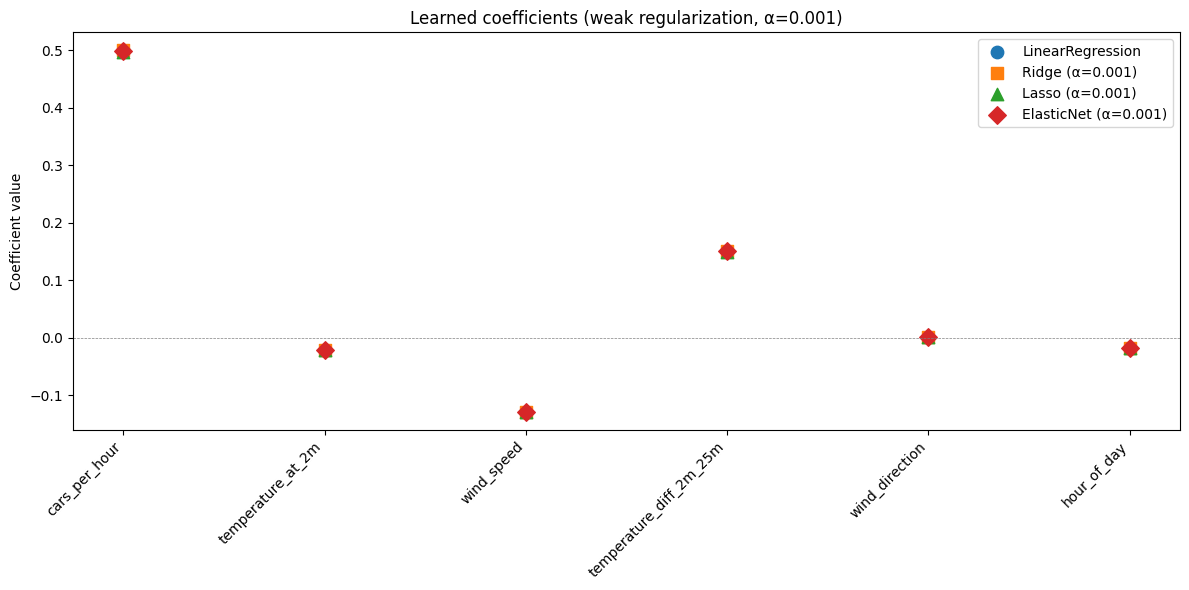

In [29]:
# --- Exercise 3.1: Coefficient scatter plot (alpha=0.001) ---
feature_names = list(X.columns)
alpha_weak = 0.001

lr_model = LinearRegression().fit(X, y)
ridge_model = Ridge(alpha=alpha_weak).fit(X, y)
lasso_model = Lasso(alpha=alpha_weak).fit(X, y)
elasticnet_model = ElasticNet(alpha=alpha_weak).fit(X, y)

fig, ax = plt.subplots(figsize=(12, 6))
x_idx = np.arange(len(feature_names))
ax.scatter(x_idx, lr_model.coef_, label='LinearRegression', marker='o', s=80)
ax.scatter(x_idx, ridge_model.coef_, label=f'Ridge (α={alpha_weak})', marker='s', s=80)
ax.scatter(x_idx, lasso_model.coef_, label=f'Lasso (α={alpha_weak})', marker='^', s=80)
ax.scatter(x_idx, elasticnet_model.coef_, label=f'ElasticNet (α={alpha_weak})', marker='D', s=80)
ax.set_xticks(x_idx)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.set_ylabel('Coefficient value')
ax.set_title('Learned coefficients (weak regularization, α=0.001)')
ax.legend()
ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')
plt.tight_layout()
plt.show()

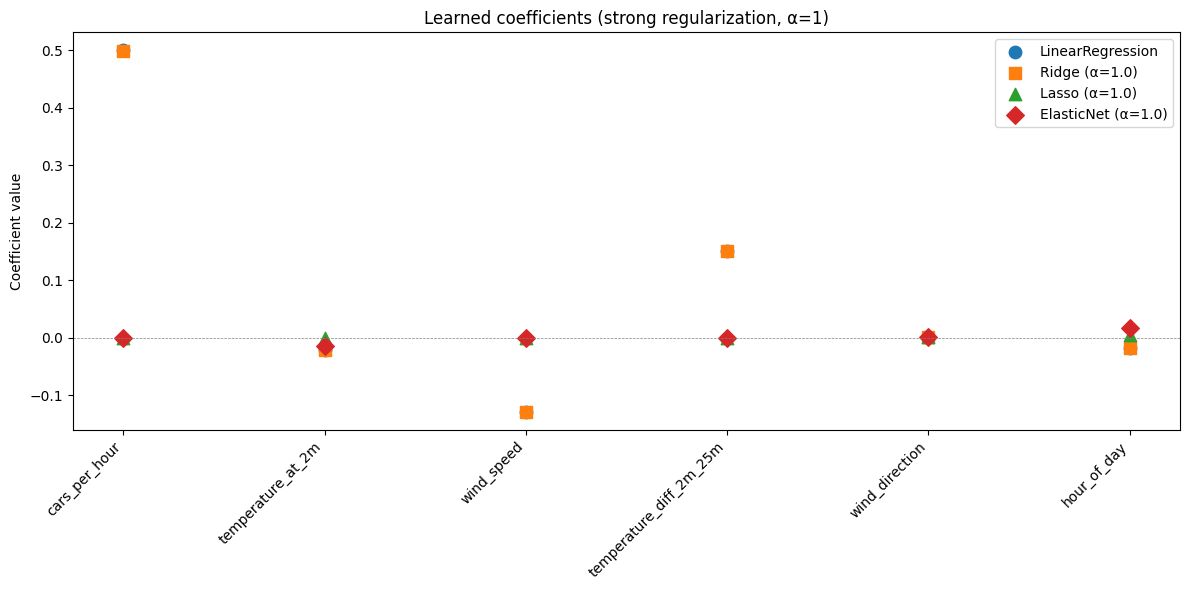

In [30]:
# --- Exercise 3.2: Coefficient scatter plot (alpha=1) ---
alpha_strong = 1.0

ridge_model_s = Ridge(alpha=alpha_strong).fit(X, y)
lasso_model_s = Lasso(alpha=alpha_strong).fit(X, y)
elasticnet_model_s = ElasticNet(alpha=alpha_strong).fit(X, y)

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x_idx, lr_model.coef_, label='LinearRegression', marker='o', s=80)
ax.scatter(x_idx, ridge_model_s.coef_, label=f'Ridge (α={alpha_strong})', marker='s', s=80)
ax.scatter(x_idx, lasso_model_s.coef_, label=f'Lasso (α={alpha_strong})', marker='^', s=80)
ax.scatter(x_idx, elasticnet_model_s.coef_, label=f'ElasticNet (α={alpha_strong})', marker='D', s=80)
ax.set_xticks(x_idx)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.set_ylabel('Coefficient value')
ax.set_title('Learned coefficients (strong regularization, α=1)')
ax.legend()
ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')
plt.tight_layout()
plt.show()